In [1]:
# This jupyter notebook contains information for analyzing data from 
# a thermal noise simulation with a isotropica algaas coating and a 
# fused silica substrate.

# In this notebook we analyze the coating energy and the coating thermal
# noise. We compare the numerically simulated data to four different
# analytic equations:

# 1.) Geoffrey Lovelace's Paper: https://arxiv.org/pdf/1707.07774.pdf
# 2.) Ting Hong's Paper:         https://doi.org/10.1103/PhysRevD.87.082001
# 3.) Greg Harry's Paper:        https://doi.org/10.1088/0264-9381/19/5/305
# 4.) Analytical equations I derived

# Contact Samuel if you have any questions

In [2]:
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FuncFormatter, MaxNLocator

In [3]:
# Variables used in the analytic solutions.

T  = 300. # Temperature
f  = 100.
F0 = 0.001
d  = 6.83E-6 # Thickness of mirror
R  = 12500.0 # Mirror Radius
kB = 1.3806488E-23 # Boltzmans constant
r0 = 176.77669534E-6 # beam width
wm = r0 * math.sqrt(2)

# These variables define the loss angles written in config_multloss.yaml
phiSub = 1E-6
phiCoat = 2.5E-5
# We can define different loss angles for the bulk/shear components of the coating.
BulkLossAngle = 2.5E-5
ShearLossAngle = 2.5E-5


In [4]:
# Bring in the numerical results
data = np.genfromtxt("NeumannOnBot.dat")

# Get the substrate, coating, and total energy
subEnergy_numerical = data[:,2]
coatEnergy_numerical = data[:,3]
totalEnergy_numerical = data[:,1]

# Get the value of the coating energy in the last cycle.
# In order to get the correct units, we have to multiply it by an order of magnitude correction.
SubEnergyNumerical = subEnergy_numerical[-1] * 1E-6
CoatEnergyNumerical = coatEnergy_numerical[-1] * 1E-6
TotalEnergyNumerical = totalEnergy_numerical[-1] * 1E-6

# Get the bulk and shear energies calculated.
bulkEnergy_numerical = data[:,10]
shearEnergy_numerical = data[:,11]

# Get the value of the bulk/shear energy in the last cycle.
# We will call this the "true" value and compare it to the analytic calculation.
BulkEnergyNumerical = bulkEnergy_numerical[-1] * 1E-6
ShearEnergyNumerical = shearEnergy_numerical[-1] * 1E-6

# Get the coating and total thermal noise
coatthermalnoise_numerical = data[:, 5]
totalthermalnoise_numerical = data[:, 6]

# Get the value of the coating/total thermal noise in the last cycle.
# In the code, the value outputted is multiplied by sqrt(f), so we have to divide that out in order to compare to the analytic solutions. 
CoatThermalNoiseNumerical = coatthermalnoise_numerical[-1] / np.sqrt(f)
TotalThermalNoiseNumerical = totalthermalnoise_numerical[-1] / np.sqrt(f)

In [5]:
# Below these cells are all of the equations that we are going to need. 

# We have tested analytics equations and found the that Hong et al+ analytic equation does not agree with our analytic equation as well as the Greg Harry analytic equation.

######################################################################
######################################################################

# Here we find the bulk and shear moduli for the coating and substrate. You can define the bulk/shear modulii in terms of the youngs modulus and poisson ratio or you can define these two modulii in terms of the lamé parameters. 

# If you choose to define the bulk/shear modulus in terms of the lamé parameters, you must then define the young modulus and poisson ratio in terms of the bulk and shear modulus. If you instead choose to define the bulk and shear modulus in terms of the poisson ratios and youngs modulus of the coating/substrate, you must first define the poisson ratio and youngs modulus of the coating/substrate.

###############################################################################
#     These are the bulk and shear modulus taken from Thorne and Blandford    #
###############################################################################
# The value for these poisson ratios are given in 
# https://arxiv.org/pdf/1707.07774.pdf


# Possion ratio and Youngs modulus for a fused silica substrate.
sigmaSub = 0.17
ymSub = 72.E9

# Possion ratio and Youngs modulus for a fused silica coating.
sigmaCoat = 0.32
ymCoat = 100.E9

# Bulk and shear modulus for the coating, taken from Thorne + Blanford eq. 11.39
# We refer to mu as the shear modulus and K as the bulk modulus.

mu_coating = ymCoat/(2*(1 + sigmaCoat))
K_coating  = ymCoat/(3*(1 - 2*sigmaCoat))

# Bulk and shear modulus for the substrate, , taken from Thorne + Blanford eq. 11.39
mu_substrate = ymSub / (2*(1 + sigmaSub))
K_substrate  = ymSub / (3*(1 - 2*sigmaSub))

########################################################################
# These are the bulk and shear modulus in terms of the lame parameters #
########################################################################

# Save all variables here.
#lame_lambda_FusedSilica = 0.0158508
#lame_mu_FusedSilica = 0.0307692
#lame_lambda_Ta2O5 = 0.0484794
#lame_mu_Ta2O5 = 0.0569106
#lame_lambda_AlGaAs = 0.0673401
#lame_mu_AlGaAs = 0.0378788

# Lamé parameters for analytic equation in Thorne + Blandford
#lame_mu_coating     = 0.0307692
#lame_lambda_coating = 0.0158508

#lame_mu_substrate     = 0.0307692
#lame_lambda_substrate = 0.0158508

# In the literature, these equations are also referred to as the first and second Lamé coefficents.
# They are discussed at the end of section 11.3.3.

#mu_substrate = lame_mu_substrate
#K_substrate  = lame_lambda_substrate + ((2 * mu_substrate)/3)

#mu_coating = lame_mu_coating 
#K_coating  = lame_lambda_coating + ((2 * mu_coating)/3) 

#################################################################################
# These are the Young's modulus and Poisson Ratio taken from Thorne + Blandford #
#################################################################################

# These are found in equation 11.39 of Thorne + Blandford.
#sigmaSub = ((3 * K_substrate) - (2 * mu_substrate)) / (2* ((3 * K_substrate) + mu_substrate))
#ymSub = (9 * mu_substrate * K_substrate) / ((3 * K_substrate) + mu_substrate)

#sigmaCoat =  ((3 * K_coating) - (2 * mu_coating)) / (2* ((3 * K_coating) + mu_coating))
#ymCoat = (9 * mu_coating * K_coating) / ((3 * K_coating) + mu_coating)

In [6]:
# Harry analytic equations (eq. 17-19) for finding the coating energy
# https://doi.org/10.1088/0264-9381/19/5/305

# Energy in the substrate
analytic_harry_substrate_energy = ((math.pow(F0, 2) * (1 - math.pow(sigmaSub, 2)) ) / (2 * math.sqrt(math.pi) * wm * ymSub))/F0**2

# Energy in the coating
analytic_harry_coating_energy = ((((d/(math.sqrt(math.pi) * wm)) * (((ymCoat * (1 + sigmaSub) * math.pow((1 - 2*sigmaSub), 2 )) + (ymSub * sigmaCoat * (1 + sigmaCoat) * (1- 2*sigmaSub))) / (ymSub * (1 + sigmaCoat) * ( 1 - sigmaCoat) * ( 1 - sigmaSub)))) + ((d/(math.sqrt(math.pi) * wm)) * (( (ymSub * (1 + sigmaCoat) * (1 - 2 * sigmaCoat)) - (ymCoat * sigmaCoat * (1 + sigmaSub) * ( 1- 2 * sigmaSub)) ) / (ymCoat * ( 1 - sigmaCoat) * (1 + sigmaSub) * (1 - sigmaSub))))) * ((math.pow(F0, 2) * (1 - math.pow(sigmaSub, 2)) ) / (2 * math.sqrt(math.pi) * wm * ymSub))) / F0**2

# Total Energy
analytic_harry_total_energy = analytic_harry_substrate_energy + analytic_harry_coating_energy

print("The coating energy given in the Greg Harry paper is: ", analytic_harry_coating_energy, ".")
print("The substrate energy given in the Greg Harry paper is: ", analytic_harry_substrate_energy, ".")
print("The total energy given in the Greg Harry paper is: ", analytic_harry_total_energy, ".")


The coating energy given in the Greg Harry paper is:  3.4442330585854996e-10 .
The substrate energy given in the Greg Harry paper is:  1.5219014012467518e-08 .
The total energy given in the Greg Harry paper is:  1.5563437318326068e-08 .


In [7]:
# These equations are ones I derived. They are the analytic solutions to the bulk/shear energies.
# We define the coating energy in terms of the bulk/shear energies which are defined in terms of 
# bulk/shear modulus.

# Equation 17
K_theta = (K_substrate + (mu_substrate / 3) + mu_coating) / ( (K_coating + ((4 / 3) * mu_coating))*(K_substrate + (mu_substrate/3)) )
# Equation 18
K_zz = (K_substrate + (mu_substrate / 3) + (mu_coating / 3) - (K_coating / 2) ) / ( (K_coating + ((4 / 3) * mu_coating))*(K_substrate + (mu_substrate/3)) )

# The energies
my_bulk_energy = (d * K_coating * pow(K_theta, 2))
my_shear_energy = ((2 * d * mu_coating  * (pow((K_theta - K_zz), 2) + pow(K_zz, 2))) - ((2 * d * mu_coating * pow(K_theta, 2))/3))

# Coating Energy
my_analytic_coating_energy = (my_bulk_energy + my_shear_energy) / (4 * math.pi * r0**2)

my_BulkEnergy_Divided_By_ShearEnergy = my_bulk_energy/my_shear_energy

print("Analytic Bulk Energy is:   ", my_bulk_energy)
print("Analytic Shear Energy is:  ", my_shear_energy)
print("Analytic Coating Energy is ", my_analytic_coating_energy)
print("Analytic Bulk Energy Divided By Shear Energy is: ", my_BulkEnergy_Divided_By_ShearEnergy)



Analytic Bulk Energy is:    1.0145840187067472e-16
Analytic Shear Energy is:   3.379631412197231e-17
Analytic Coating Energy is  3.444233058585499e-10
Analytic Bulk Energy Divided By Shear Energy is:  3.0020552390567534


In [8]:
# Lovelace analytic solution (eq. 43) for coating thermal noise
# https://arxiv.org/pdf/1707.07774.pdf
analytic_geoffrey_coating_thermal_noise = np.sqrt((2*kB*T/((math.pi**2)*f))*((1-(sigmaSub**2))/(wm*ymSub))*(d/wm)*((phiCoat)/(ymSub*ymCoat*(1-sigmaCoat**2)*(1-sigmaSub**2)))*(ymCoat**2*(1+sigmaSub)**2*(1-2*sigmaSub)**2+ymSub**2*(1+sigmaCoat)**2*(1-2*sigmaCoat)))

# Hong anlaytic solution (eq. 69) for coating energy providing that the substrate and coating are the same material.
# https://doi.org/10.1103/PhysRevD.87.082001

analytic_hong_coating_thermal_noise_equalsub = np.sqrt((((8*kB*T*d)*(1 - sigmaCoat - (2*np.square(sigmaCoat))))/(3 * f * ymCoat * (math.pi**2) * (wm**2))) * ((2 * BulkLossAngle * (1 + sigmaCoat)) + (ShearLossAngle * (1 - 2 * sigmaCoat))))


print(analytic_geoffrey_coating_thermal_noise)
print(analytic_hong_coating_thermal_noise_equalsub)

6.738660338279832e-19
6.602006102490823e-19


In [9]:
# Eq 62-64
# https://doi.org/10.1103/PhysRevD.87.082001

# This is the more general equation, allowing for a different coating and substrate as well as a different bulk and shear loss angles.

hong_BulkEnergy = (BulkLossAngle * (1 - (2 * sigmaCoat))) * ((((ymCoat/(ymSub**2))) * ((1 - (2 * sigmaSub))**2) * ((1 + sigmaSub)**2) * (1/((1 - sigmaCoat)**2))) + ((2 * (1 - (2*sigmaSub)) * (1 + sigmaSub) * (1 + sigmaCoat)) / (ymSub * ((1 - sigmaCoat)**2))) + ((1 + sigmaCoat)**2)/(ymCoat * ((1 - sigmaCoat)**2)))


hong_ShearEnergy = (2 * ShearLossAngle) * ( (ymCoat/(ymSub**2)) * ((1 - (2 * sigmaSub))**2) * ((1 + sigmaSub)**2) * (1/((1 - sigmaCoat)**2)) - (((1 + sigmaCoat)*(1 - (2 * sigmaCoat)) *(1 - (2*sigmaSub))*(1+sigmaSub))/(ymSub* ((1 - sigmaCoat)**2))) + ((((1 - (2 * sigmaCoat))**2) * (1 + sigmaCoat)) / (ymCoat * ((1 - sigmaCoat)**2))))


analytic_hong_coating_thermal_noise = np.sqrt(((4 * kB * T * d)/((math.pi**2) * f * 3 * (wm**2))) * (hong_BulkEnergy + hong_ShearEnergy))

print(analytic_hong_coating_thermal_noise)

1.1036051789085636e-18


In [10]:
# We are going to be comparing how accurate one solution is to another, so we are going to define a percent error function. Here "a" is the true value, or the value of the analytic solution.
def PercentDifference(a, b):
    return(100 * np.abs(a-b)/a)


In [11]:
# Before we analyze any data, we are going to compare our numerical results to the analytic equations.

print("These comparisons are for a effective isotropic AlGaAs coating with a fused silica substrate.")
print("The numerically calculated coating energy is: ", CoatEnergyNumerical, ".")
print("The analytic solution Greg Harry presents says the coating energy is: ", analytic_harry_coating_energy, ". The percent error between our numerical solution and the analytic formula is: ",PercentDifference(analytic_harry_coating_energy, CoatEnergyNumerical),"%.")
print("The analytic solution I provided says the coating energy is: ", my_analytic_coating_energy,". The percent error between our numerical solution and the analytic equation is: ", PercentDifference(my_analytic_coating_energy, CoatEnergyNumerical))


These comparisons are for a fused silica coating with a fused silica substrate.
The numerically calculated coating energy is:  2.9481711452215e-10 .
The analytic solution Greg Harry presents says the coating energy is:  3.4442330585854996e-10 . The percent error between our numerical solution and the analytic formula is:  14.402681378586081 %.
The analytic solution I provided says the coating energy is:  3.444233058585499e-10 . The percent error between our numerical solution and the analytic equation is:  14.40268137858607


In [12]:
# Lets next compare our anlytic solutions for the coating thermal noise to the numerical results.

print("The numerically calculated coating thermal noise is: ", CoatThermalNoiseNumerical, ".")
print("The analytic solution Ting Hong presents says the coating thermal noise is: ", analytic_hong_coating_thermal_noise, ". The percent error between our numerical solution and the analytic formula is: ",PercentDifference(analytic_hong_coating_thermal_noise, CoatThermalNoiseNumerical),"%.")
print("The analytic solution Geoffrey provided says the coating thermal noise is: ", analytic_geoffrey_coating_thermal_noise,". The percent error between our numerical solution and the analytic equation is: ", PercentDifference(analytic_geoffrey_coating_thermal_noise, CoatThermalNoiseNumerical), ".")

The numerically calculated coating thermal noise is:  6.2345289586918e-19 .
The analytic solution Ting Hong presents says the coating thermal noise is:  1.1036051789085636e-18 . The percent error between our numerical solution and the analytic formula is:  43.50761415547556 %.
The analytic solution Geoffrey provided says the coating thermal noise is:  6.738660338279832e-19 . The percent error between our numerical solution and the analytic equation is:  7.4811810401579075 .


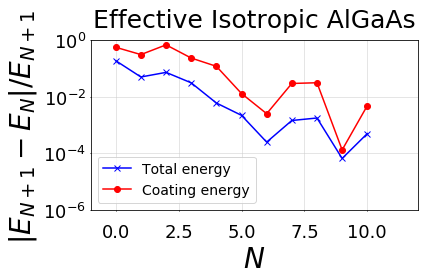

In [13]:
# Now that we have seen that our results are close to the analytic solution, we can begin to plot the data. This plot shows how the total/coating energy converge with resolution. We are going to define the same variables again from above, but now we are not going to manipulate them to have agree with the analytic solution.

totalEnergy = data[:,1]
totalEnergyDropLast = totalEnergy[:-1]
totalEnergyDropFirst = totalEnergy[1:]
totalEnergyDiff = np.abs(totalEnergyDropLast - totalEnergyDropFirst)
totalEnergyDiffFrac = totalEnergyDiff / totalEnergyDropLast

coatEnergy = data[:,3]
coatEnergyDropLast = coatEnergy[:-1]
coatEnergyDropFirst = coatEnergy[1:]
coatEnergyDiff = np.abs(coatEnergyDropLast - coatEnergyDropFirst)
coatEnergyDiffFrac = coatEnergyDiff / coatEnergyDropLast

fig_1 = plt.gcf()
ax_1 = plt.gca()

gridwidth_1=0.5
gridcolor_1=(0.8,0.8,0.8)

myAxisLabelSize_1=28
myTickLabelSize_1=18
myLegendLabelSize_1=14
myTitleSize_1=25

ax_1.plot(data[:,0][:-1], totalEnergyDiffFrac, marker='x', label='Total energy', color='b')
ax_1.plot(data[:,0][:-1], coatEnergyDiffFrac, marker='o', label='Coating energy', color='r')

ax_1.set_xlim([0,12])
ax_1.set_ylim([1e-6,1e0])

ax_1.set_yscale('log')
ax_1.set_xlim([-1,12])

ax_1.set_xlabel('$N$', fontsize=myAxisLabelSize_1)
ax_1.set_ylabel('$|E_{N+1} - E_{N}|/ E_{N+1}$ ', fontsize=myAxisLabelSize_1)

ax_1.tick_params(axis='x', labelsize=myTickLabelSize_1, pad=12, length=1)
ax_1.tick_params(which='minor', length=1)
ax_1.tick_params(axis='y', labelsize=myTickLabelSize_1, length=1)

ax_1.grid(b=True, which='major', color=gridcolor_1, linestyle='solid', linewidth=gridwidth_1)

ax_1.set_title('Effective Isotropic AlGaAs', fontsize=myTitleSize_1, color='k', y=1.04)
ax_1.legend(loc='lower left', fontsize=myLegendLabelSize_1)

fig_1.tight_layout()
pdf_1 = PdfPages('TotalAndCoatingEnergyConvergence.pdf')
pdf_1.savefig()
pdf_1.close()

In [35]:
# All defunct for now

# This is the amplitude spectral density, equation 43 in Geoffreys paper.
# Note that the amplitude spectral density is usually referred to as the thermal noise.

# Note that we have to put the units back into the equations here since we put units into the code.


# These equations define the coating thermal noise.

#asd = np.sqrt((2*kB*T/((math.pi**2)*f))*((1-(sigmaSub**2))/(wm*ymSub))*(d/wm)*((phiCoat)/(ymSub*ymCoat*(1-sigmaCoat**2)*(1-sigmaSub**2)))*(ymCoat**2*(1+sigmaSub)**2*(1-2*sigmaSub)**2+ymSub**2*(1+sigmaCoat)**2*(1-2*sigmaCoat)))

# This is the power spectral density
#psd = (2*kB*T/((math.pi**2)*f))*((1-(sigmaSub**2))/(wm*ymSub))*(d/wm)*((phiCoat)/(ymSub*ymCoat*(1-sigmaCoat**2)*(1-sigmaSub**2)))*(ymCoat**2*(1+sigmaSub)**2*(1-2*sigmaSub)**2+ymSub**2*(1+sigmaCoat)**2*(1-2*sigmaCoat))

# This is supposedly equation 19 in the thermal noise paper by Geoffrey, the coating energy.
# However I do not have the term phi(f) that is in the paper. So I don't think that this equation will work.
# In fact, this equation is for the total thermal noise.
#ge_AnalyticCoatingEnergy = ((math.pi * f * pow(F0, 2))/ (4 * kB * T * phiCoat)) * psd

#numCoatThermalNoise = numCoatThermalNoise / np.sqrt(f)

#CoatingEnergyPercentDifference = np.abs(asd - numCoatThermalNoise)/asd

###################################################################################################
###################################################################################################

#print("The asd is ", asd,".\n")
#print("The psd is ", psd,".\n")
#print(ge_AnalyticCoatingEnergy)
#print("The numerical coating thermal noise is", numCoatThermalNoise,".")
#print("The percent difference is", CoatingEnergyPercentDifference * 100 ,"%.")

#print("The coating energy is ", AnalyticCoatingEnergy, ".")

###################################################################################################
###################################################################################################

# Let us do a little excercise:

# According to equation 29, the coating energy is 
# U_phi = U_Bulk * phiBulk + U_Shear * phiShear




In [37]:
# The total thermal noise. In the paper, we only plot this for the a FusedSilica coating/substrate.

#TotalAmpThermalNoise = np.sqrt(((2*kB*T)/(math.pi**(1.5)*f))*((1-sigmaSub**2)/(wm*ymSub))*phiSub)
#TotalThermalNoise = (((2*kB*T)/(math.pi**(1.5)*f))*((1-sigmaSub**2)/(wm*ymSub))*phiSub)
#print(totalAmpNoiseNumerical, " " , TotalThermalNoise, " ", TotalAmpThermalNoise)



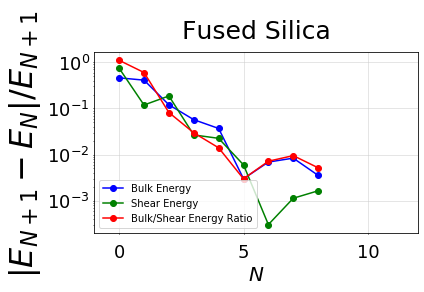

In [40]:
# This is a plot that determines if the bulk and shear energy (as well as their ratio) converge.
#BulkLossAngle = 1E-6
#ShearLossAngle = 1E-6
#phiBDividedByphiS = BulkLossAngle / ShearLossAngle

# Get the bulk and shear energies calculated.
#BulkEnergyNum  = data[:,10]
#BulkEnergyDropLast = BulkEnergyNum[:-1]
#BulkEnergyDropFirst = BulkEnergyNum[1:]
#BulkEnergyDiff = np.abs(BulkEnergyDropLast - BulkEnergyDropFirst)
#BulkEnergyDiffFrac = BulkEnergyDiff / BulkEnergyDropLast

#ShearEnergyNum = data[:,11]
#ShearEnergyDropLast = ShearEnergyNum[:-1]
#ShearEnergyDropFirst = ShearEnergyNum[1:]
#ShearEnergyDiff = np.abs(ShearEnergyDropLast - ShearEnergyDropFirst)
#ShearEnergyDiffFrac = ShearEnergyDiff / ShearEnergyDropLast

#RatioNum = data[:,10] / data[:,11]
#RatioDropLast = RatioNum[:-1]
#RatioDropFirst = RatioNum[1:]
#RatioDiff = np.abs(RatioDropLast - RatioDropFirst)
#RatioDiffFrac = RatioDiff / RatioDropLast

#RatioNumDividedByLossAngles = (data[:,10] / data[:,11]) / phiBDividedByphiS
#RatioNumDividedByLossAnglesDropLast = RatioNumDividedByLossAngles[:-1]
#RatioNumDividedByLossAnglesDropFirst = RatioNumDividedByLossAngles[1:]
#RatioNumDividedByLossAnglesDiff = np.abs(RatioDropLast - RatioDropFirst)
#RatioNumDividedByLossAnglesDiffFrac = RatioNumDividedByLossAnglesDiff / #RatioNumDividedByLossAnglesDropLast


# Set the values of phiB and phiS that will appear in the legend of the graphs
# phiB_patch = mpatches.Patch(label='$\phi_{B} = 2.5e-5$')
# phiS_patch = mpatches.Patch(color='blue', label='$\phi_{S} = 2.5e-5$')

#myAxisLabelSize_2 = 20
#myTickLabelSize_2 = 18
#myLegendLabelSize_2 = 10
#myTitleSize_2 = 25

#gridwidth_2 = 0.5
#gridcolor_2 = (0.8,0.8,0.8)

#ax_2 = plt.gca()

# Plot the value of bulk/shear / phib/phis versus resolution
#ax_2.plot(data[:,0][:-1], BulkEnergyDiffFrac, marker='o',label='Bulk Energy', color='b')
#ax_2.plot(data[:,0][:-1], ShearEnergyDiffFrac, marker='o',label='Shear Energy', color='g')
#ax_2.plot(data[:,0][:-1], RatioDiffFrac, marker='o',label='Bulk/Shear Energy Ratio', color='r')

#ax_2.set_yscale('log')
#ax_2.set_xlim([-1,12])

#ax_2.set_xlabel('$N$', fontsize=myAxisLabelSize_2)
#ax_2.set_ylabel('$|E_{N+1} - E_{N}|/ E_{N+1}$ ', fontsize= 32)

#ax_2.tick_params(axis='x', labelsize=myTickLabelSize_2, pad=10, length=1)
#ax_2.tick_params(which='minor', length=1)
#ax_2.tick_params(axis='y', labelsize=myTickLabelSize_2, length=1)

#ax_2.grid(b=True, which='major', color=gridcolor_2, linestyle='solid', linewidth=gridwidth_2)

#ax_2.set_title('Fused Silica', fontsize=myTitleSize_2, color='k', y=1.04)
#ax_2.legend(loc='lower left', fontsize=myLegendLabelSize_2)

#fig_2 = plt.gcf()
#fig_2.tight_layout()
#pdf_2 = PdfPages('BulkAndShearEnergyConvergence.pdf')
#pdf_2.savefig()
#pdf_2.close()

In [41]:
# Not sure that these plots below actually show anything useful.


# This plot shows how far the previous value found by the code (BulkEnergy/ShearEnergy)
# differs from the last value found.

RealResult = EnergyDividedByPhi[-1]
MyList = []
for p in EnergyDividedByPhi:
    MyList = abs(RealResult - EnergyDividedByPhi)

ax3 = plt.gca()

ax3.plot(data[:,0], MyList, marker='o', color='r')
ax3.set_yscale('log')

ax3.set_xlabel('$N$', fontsize=myAxisLabelSize_2)
ax3.set_ylabel('$Final Value - N_Value$', fontsize=myAxisLabelSize_2)

ax3.tick_params(axis='x', labelsize=myTickLabelSize_2, pad=12, length=1)
ax3.tick_params(which='minor', length=1)
ax3.tick_params(axis='y', labelsize=myTickLabelSize_2, length=1)
ax3.grid(b=True, which='major', color=gridcolor_2, linestyle='solid', linewidth=gridwidth_2)

ax3.set_title('AlGaAs (effective isotropic)', fontsize=myTitleSize_2, color='k', y=1.04)



ax3.legend(loc='lower left', fontsize=myLegendLabelSize_2)
#ax.legend(loc='lower left', fontsize=myLegendLabelSize)

fig3 = plt.gcf()
fig3.tight_layout()
pdf3 = PdfPages('FinalValueMinusNValue.pdf')
pdf3.savefig()
pdf3.close()

NameError: name 'EnergyDividedByPhi' is not defined

In [15]:
EnergyDividedByPhiDropLast = EnergyDividedByPhi[:-1]
EnergyDividedByPhiDropFirst = EnergyDividedByPhi[1:]
EnergyDividedByPhiDiff = abs(EnergyDividedByPhiDropLast - EnergyDividedByPhiDropFirst)
EnergyDiffFrac = EnergyDividedByPhiDiff / EnergyDividedByPhiDropLast

myTitleSize3 = 20
myTickLabelSize3=18
myLegendLabelSize3 =8
myAxisLabelSize3 = 10

gridwidth3=0.5
gridcolor3=(0.8,0.8,0.8)

ax3 = plt.gca()

ax3.plot(data[:,0][:-1], EnergyDiffFrac, marker='o', color='r')
ax3.set_yscale('log')

ax3.set_xlabel('$N$', fontsize=myAxisLabelSize3)
ax3.set_ylabel('$|E_{N+1} - E_{N}|/ E_{N+1}$', fontsize=myAxisLabelSize3)

ax3.tick_params(axis='x', labelsize=myTickLabelSize3, pad=12, length=1)
ax3.tick_params(which='minor', length=1)
ax3.tick_params(axis='y', labelsize=myTickLabelSize3, length=1)
ax3.grid(b=True, which='major', color=gridcolor3, linestyle='solid', linewidth=gridwidth3)

ax3.set_title('Bulk and Shear Energy', fontsize=myTitleSize3, color='k', y=1.04)


ax3.legend(handles=[phiB_patch, phiS_patch],loc='lower left', fontsize=myLegendLabelSize3)

fig3 = plt.gcf()
fig3.tight_layout()
pdf3 = PdfPages('EnergyConvergence.pdf')
pdf3.savefig()
pdf3.close()

NameError: name 'EnergyDividedByPhi' is not defined